In [1]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import time
import ast
import random
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import max_error, mean_squared_error

In [2]:
import csv
with open("C:/Users/danie/Downloads/SNR_dataset_0.2dB_per_km.txt", 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(";") for line in stripped if line)
    with open("C:/Users/danie/Downloads/SNR_dataset_0.2dB_per_km.csv", 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('span', 'interfers', 'deltaf', 'snr'))
        writer.writerows(lines)

In [3]:
df=pd.read_csv("C:/Users/danie/Downloads/SNR_dataset_0.2dB_per_km.csv")
df.head(5)

,span,interfers,deltaf,snr
0,60 60 60 60 60,5,50.0129,21.4016
1,70 70 60,14,50.0129,21.7621
2,50 50 50 50 50 50 50 50 50 50 50 50 50 50 50,17,50.0129,19.3127
3,70 70 70 70 70,29,50.0129,21.0628
4,70 70 70 70 70,9,50.0129,21.2568


In [4]:
def read_dataset(df):
    span_list=df["span"]
    interfers_list=df["interfers"]
    snr_list=df["snr"]
    return span_list,interfers_list,snr_list
    
    

In [5]:
[span_list,interfers_list,snr_list]=read_dataset(df)

Checking dimension of return value

In [6]:
print(len(span_list))
print(len(interfers_list))
print(len(snr_list))

1034
1034
1034


Compute mean and variance

In [7]:
def media(l):
    l_mean=l.mean()
    return l_mean
def varianza(l):
    l_var=l.var()
    return l_var
def deviation_standard(l):
    l_std=l.std()
    return l_std
    
    

Number of interferers

In [8]:
[inter_mean,interf_var,inter_std]=[media(interfers_list),varianza(interfers_list),deviation_standard(interfers_list)]
print("Number of Interfers:\n")
print("Mean",inter_mean)
print("Variance",interf_var)
print("Deviation Standard",inter_std)

Number of Interfers:

Mean 40.91295938104449
Variance 232.9565985907977
Deviation Standard 15.262915795836578


SNR

In [9]:
[SNR_mean,SNR_var,SNR_std]=[media(snr_list),varianza(snr_list),deviation_standard(snr_list)]

In [10]:
print("SNR:\n")
print("Mean",SNR_mean)
print("Variance",SNR_var)
print("Deviation Standard",SNR_std)

SNR:

Mean 18.511346131528047
Variance 4.25697372908957
Deviation Standard 2.0632434972851774


In [11]:
r=[]
lightpath_len=[]
for i in range(len(span_list)):
    span_list[i]=np.fromstring(span_list[i],dtype=int,sep=' ')
    r.append(len(span_list[i]))
    lightpath_len.append(sum(span_list[i]))

C:\Users\danie\AppData\Local\Temp\ipykernel_10872\1981901896.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  span_list[i]=np.fromstring(span_list[i],dtype=int,sep=' ')


Metrics for Number of spans

In [12]:
span_array=np.array(r)
ligth_array=np.array(lightpath_len)
[span_mean,span_var,span_std]=[media(span_array),varianza(span_array),deviation_standard(span_array)]
print("Number of Spans:\n")
print("Mean",span_mean)
print("Variance",span_var)
print("Deviation Standard",span_std)

Number of Spans:

Mean 15.828820116054159
Variance 243.2289179502336
Deviation Standard 15.595798086351131


Metrics for Ligthpath length

In [13]:
[lightpath_mean,lightpath_var,lightpath_std]=[media(ligth_array),varianza(ligth_array),deviation_standard(ligth_array)]
print("Lightpath length:\n")
print("Mean",span_mean)
print("Variance",span_var)
print("Deviation Standard",span_std)

Lightpath length:

Mean 15.828820116054159
Variance 243.2289179502336
Deviation Standard 15.595798086351131


# TASK 2

Text(0, 0.5, 'SNR,dB')

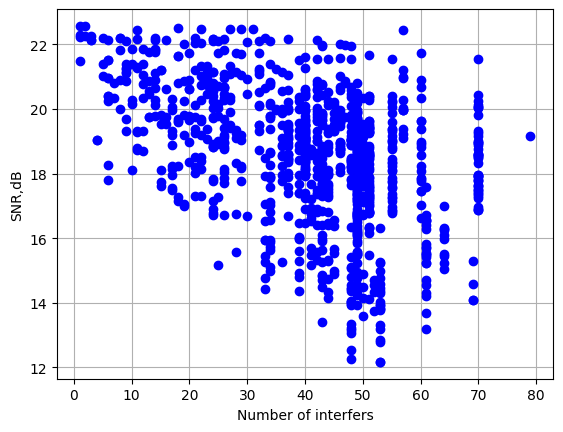

In [14]:
plt.grid()
plt.plot(df["interfers"],df["snr"], 'bo')
plt.xlabel("Number of interfers")
plt.ylabel("SNR,dB")

Text(0, 0.5, 'SNR,dB')

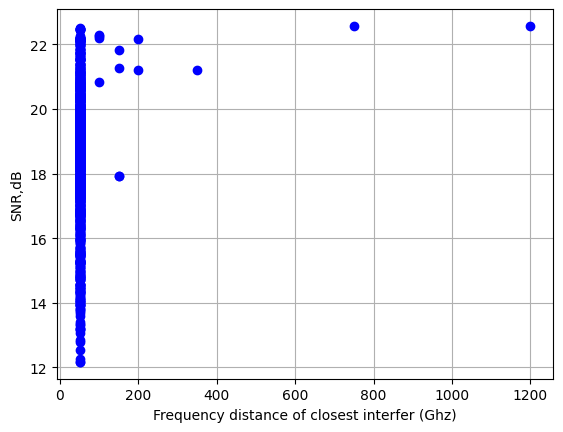

In [15]:
plt.grid()
plt.plot(df["deltaf"],df["snr"], 'bo')
plt.xlabel("Frequency distance of closest interfer (Ghz)")
plt.ylabel("SNR,dB")

Text(0, 0.5, 'SNR,dB')

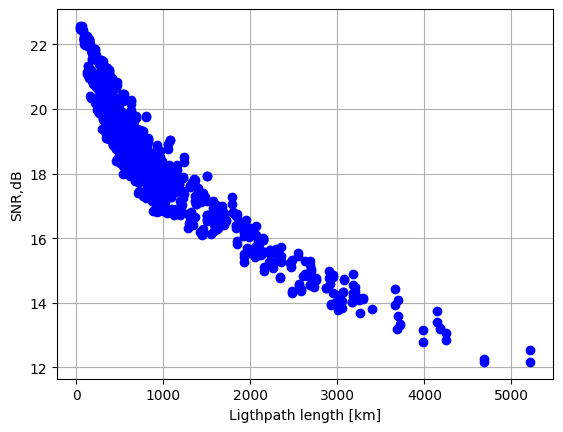

In [16]:
plt.grid()
plt.plot(ligth_array,df["snr"], 'bo')
plt.xlabel("Ligthpath length [km]")
plt.ylabel("SNR,dB")

Text(0, 0.5, 'SNR,dB')

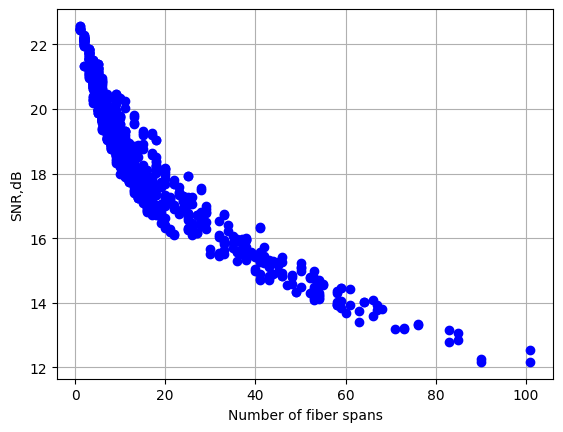

In [17]:
plt.grid()
plt.plot(span_array,df["snr"], 'bo')
plt.xlabel("Number of fiber spans")
plt.ylabel("SNR,dB")

# 3.0 REGRESSION ALGORITHM

We aim at predicting the possible mobile format for a given candidate lightpath. The first way is the following:
We'll predict SNR with lineare regression and the map the MF


We create two new columns in which we put the total length lighpath and the number of amplifier that we travers, and we drop the span columns

In [18]:
df["total_lightpath_length"]=ligth_array
df["number of span"]=span_array
df=df.drop(columns=['span'])
df.head()
df1=df.copy()

In [19]:
def mapping(snr_array):
    r=snr_array
    p=[]
    for i in range(len(r)):
        if(r[i]>=11 and r[i]<15):
            p.append("QPSK")
        elif(r[i]>=15 and r[i]<18):
            p.append("8QAM")
        elif(r[i]>=18 and r[i]<20.8):
            p.append("16QAM")
        elif(r[i]>=20.8 and r[i]<23.7):
            p.append("32QAM")
        else:
            p.append("64QAM")
    return p

In [20]:
features=['total_lightpath_length','interfers','deltaf','number of span']
X=df[features]
y=df["snr"]

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [22]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

MAPPING

SNR      MF
11dB     QPSK
15dB     8QAM
18dB     16QAM
20.8dB   32QAM
23.7dB   64QAM

In [24]:
MF_prediction=mapping(y_pred)

# 3.1.0 Metrics for evaluating my model

# 3.1.1 MSE(Mean Square Error)

It measure the average squared difference between the estimated value and the true value. Values close to zero are better. 

First: We identify the index of X test for collecting the real value of Y, and then we compare the 

In [25]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test,y_pred)
print(mse)

0.07968786544032186


# 3.1.2 RMSE(Root Mean Square Error)

Measure the efficiency of the model. 

In [26]:
rmse=math.sqrt(mse)
print(rmse)

0.2822903920439409


# 3.1.3 MAE(Mean Absolute Error)

In [27]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(y_test,y_pred)
print(mae)

0.19840238365539478


# 4.0 CLASSIFICATION ALGORITHM

In this case we want to predict the Modulation format directly and then use a ML classifier to make the prediction. 


In [28]:
df1["MF"]=mapping(df1["snr"])
df.head()

,interfers,deltaf,snr,total_lightpath_length,number of span
0,5,50.0129,21.4016,300,5
1,14,50.0129,21.7621,200,3
2,17,50.0129,19.3127,750,15
3,29,50.0129,21.0628,350,5
4,9,50.0129,21.2568,350,5


Since MF is our label but it is categorical, i map it in a numerical formato

In [29]:
df1=df1.replace(["QPSK","8QAM","16QAM","32QAM","64QAM"],[0,1,2,3,4])
df1.head()

,interfers,deltaf,snr,total_lightpath_length,number of span,MF
0,5,50.0129,21.4016,300,5,3
1,14,50.0129,21.7621,200,3,3
2,17,50.0129,19.3127,750,15,2
3,29,50.0129,21.0628,350,5,3
4,9,50.0129,21.2568,350,5,3


In [30]:
features=['total_lightpath_length','interfers','deltaf','number of span','snr']
X1=df1[features]
y1=df1["MF"]

In [31]:
from sklearn.ensemble import RandomForestClassifier
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=0)
sc1 = StandardScaler()
X_train_1 = sc.fit_transform(X_train_1)
X_test_1 = sc.transform(X_test_1)
classifier = RandomForestClassifier(n_estimators=20, random_state=0)
classifier.fit(X_train_1, y_train_1)
y_pred_1 = classifier.predict(X_test_1)

In [32]:
y_pred_1

array([2, 2, 1, 0, 2, 3, 1, 1, 0, 2, 1, 3, 3, 2, 1, 1, 2, 3, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1,
       1, 3, 1, 3, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2,
       2, 3, 3, 3, 1, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2,
       3, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2,
       0, 2, 1, 3, 0, 2, 2, 2, 3, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 1, 3, 2, 2, 2, 0, 3, 2, 1, 1, 1,
       1, 2, 3, 3, 0, 2, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 3, 2, 3, 2, 2], dtype=int64)

In [33]:
def mapping_new(y_pred):
    p=[]
    for i in range(len(y_pred)):
        if(y_pred[i]==0):
            p.append("QPSK")
        elif(y_pred[i]==1):
            p.append("8QAM")
        elif(y_pred[i]==2):
            p.append("16QAM")
        elif(y_pred[i]==3):
            p.append("32QAM")
        else:
            p.append("64QAM")
    
    return p
        

In [34]:
#y_pred_1.astype(int)
y_pred_MF=mapping_new(y_pred_1)
y_pred_MF

['16QAM',
 '16QAM',
 '8QAM',
 'QPSK',
 '16QAM',
 '32QAM',
 '8QAM',
 '8QAM',
 'QPSK',
 '16QAM',
 '8QAM',
 '32QAM',
 '32QAM',
 '16QAM',
 '8QAM',
 '8QAM',
 '16QAM',
 '32QAM',
 '8QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 'QPSK',
 '8QAM',
 '16QAM',
 '8QAM',
 '32QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 '8QAM',
 '32QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 '8QAM',
 '8QAM',
 '8QAM',
 '8QAM',
 '8QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '32QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 'QPSK',
 '8QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 '8QAM',
 '32QAM',
 '8QAM',
 '32QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '32QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 'QPSK',
 '8QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '16QAM',
 '32QAM',
 '32QAM',
 '32QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 'QPSK',
 '16QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 '16QAM',
 '8QAM',
 '16QAM',
 

At this point we can compute some metrics: Accuracy and Precision

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(accuracy_score(y_test_1,y_pred_1))


0.9951690821256038


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


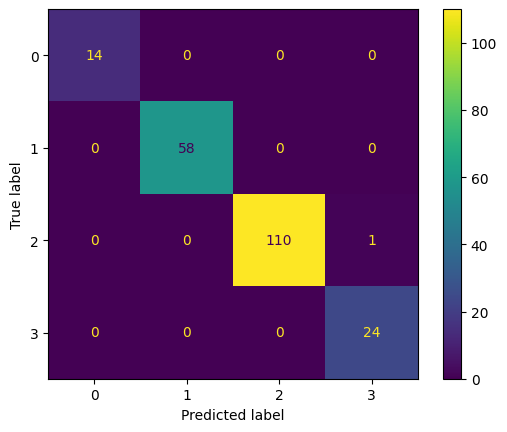

In [36]:
plot_confusion_matrix(classifier, X_test_1, y_test_1)  

In this case the confusion matrix is 4x4, because we have 4 possible MF. How we can read it ? Focusing on label 0(QPSK) we have 14 values. All of them have been predicted correctly. For 16QAM(label 2), 110 values have been predicted correctly but 1 value has been predicted wrongly as 32QAM

In [37]:
cnf_matrix = confusion_matrix(y_test_1, y_pred_1)

In [38]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [39]:
print("TPR: ",TPR )
print("TNR: ",TNR )
print("PPV: ", PPV )
print("NPV: ",NPV )
print("FPR: ",FPR )
print("FNR: ",FNR )
print("FDR: ",FDR )

TPR:  [1.         1.         0.99099099 1.        ]
TNR:  [1.         1.         1.         0.99453552]
PPV:  [1.   1.   1.   0.96]
NPV:  [1.         1.         0.98969072 1.        ]
FPR:  [0.         0.         0.         0.00546448]
FNR:  [0.         0.         0.00900901 0.        ]
FDR:  [0.   0.   0.   0.04]


Precision

In [40]:
precision=(TP)/(TP+FP)
precision

array([1.  , 1.  , 1.  , 0.96])

Recall

In [41]:
recall=(TP)/(TP+FN)
recall

array([1.        , 1.        , 0.99099099, 1.        ])

F1 score

In [42]:
F1=2*precision*(recall/precision)+recall
F1

array([3.        , 3.        , 2.97297297, 3.        ])